In [1]:
import numpy as np
import matplotlib.pyplot as plt # Collect coords into list
import osm

make: Entering directory '/home/ahmad/.cache/elevation/SRTM1'
curl -s -o spool/N09/N09E049.hgt.gz.temp https://s3.amazonaws.com/elevation-tiles-prod/skadi/N09/N09E049.hgt.gz && mv spool/N09/N09E049.hgt.gz.temp spool/N09/N09E049.hgt.gz
gunzip spool/N09/N09E049.hgt.gz 2>/dev/null || touch spool/N09/N09E049.hgt
gdal_translate -q -co TILED=YES -co COMPRESS=DEFLATE -co ZLEVEL=9 -co PREDICTOR=2 spool/N09/N09E049.hgt cache/N09/N09E049.tif 2>/dev/null || touch cache/N09/N09E049.tif
rm spool/N09/N09E049.hgt
make: Leaving directory '/home/ahmad/.cache/elevation/SRTM1'
make: Entering directory '/home/ahmad/.cache/elevation/SRTM1'
gdalbuildvrt -q -overwrite SRTM1.vrt cache/N10/N10E051.tif cache/N49/N49E009.tif cache/N09/N09E049.tif cache/N51/N51E010.tif
make: Leaving directory '/home/ahmad/.cache/elevation/SRTM1'
make: Entering directory '/home/ahmad/.cache/elevation/SRTM1'
cp SRTM1.vrt SRTM1.c6df7e33849d497bb284c49f3738a319.vrt
make: Leaving directory '/home/ahmad/.cache/elevation/SRTM1'
make: En

Warning 1: PROJ: proj_create_from_database: Open of /home/ahmad/anaconda3/envs/debug/share/proj failed
Warning 1: PROJ: proj_create_from_database: Open of /home/ahmad/anaconda3/envs/debug/share/proj failed
Warning 1: PROJ: proj_create_from_database: Open of /home/ahmad/anaconda3/envs/debug/share/proj failed
Warning 1: PROJ: proj_create_from_database: Open of /home/ahmad/anaconda3/envs/debug/share/proj failed
ERROR 1: PROJ: proj_create_from_name: Open of /home/ahmad/anaconda3/envs/debug/share/proj failed
Warning 1: PROJ: proj_create_from_database: Open of /home/ahmad/anaconda3/envs/debug/share/proj failed


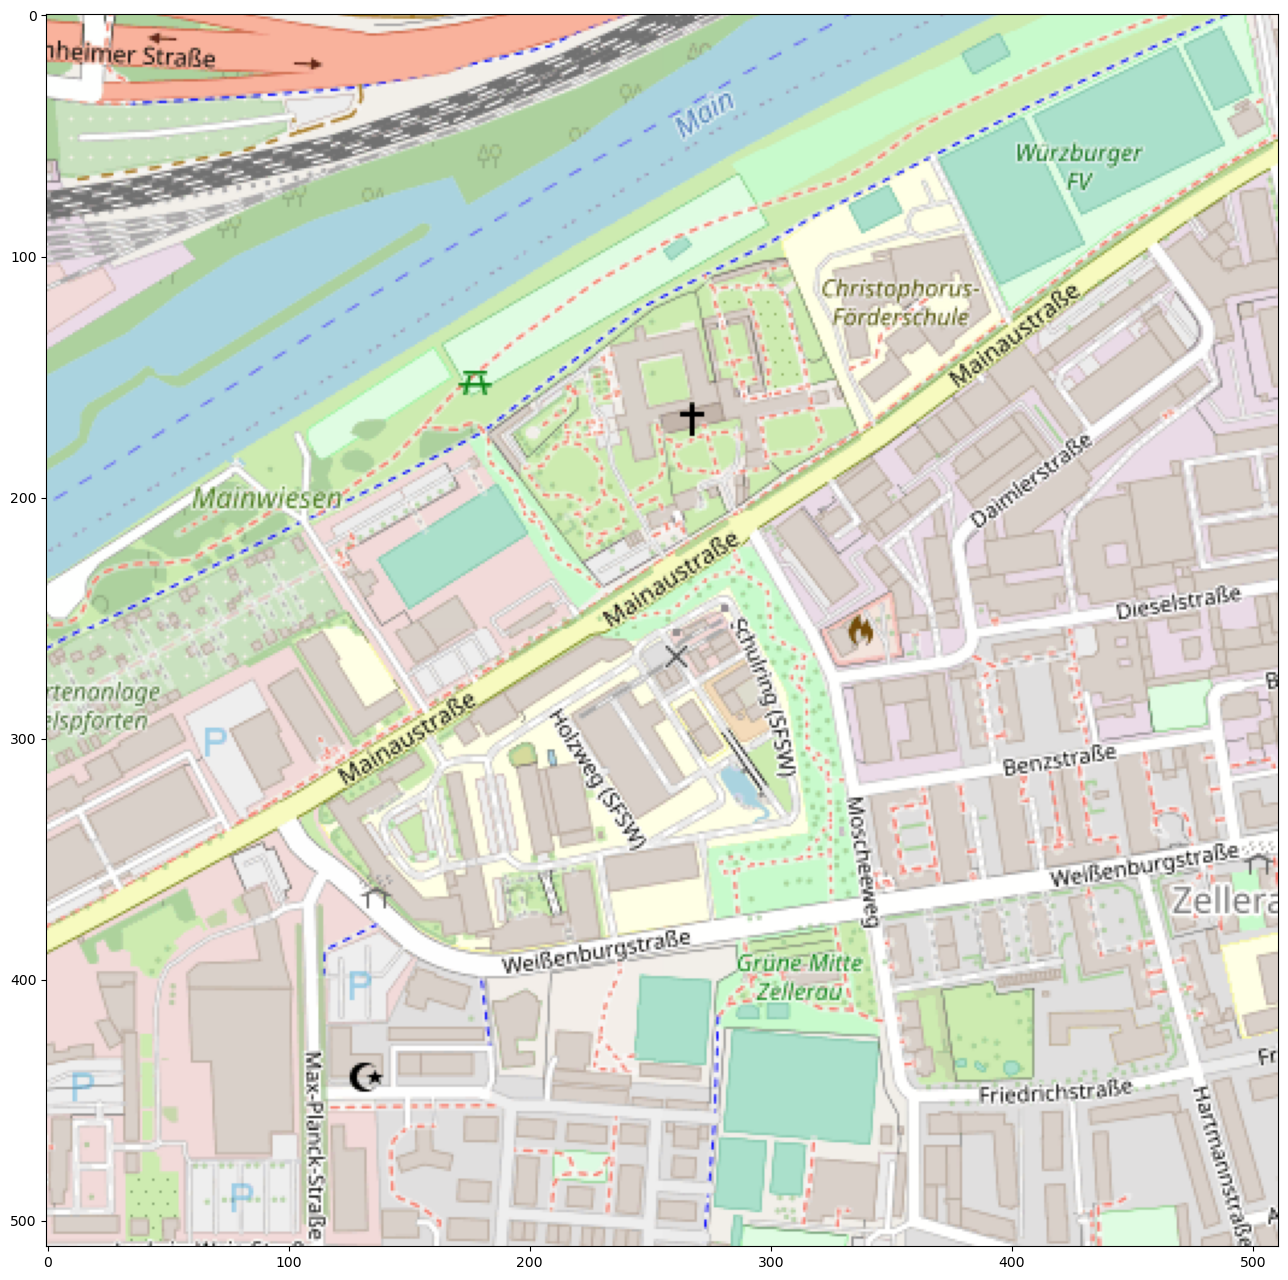

In [2]:
# Example
op = osm.Overpass()
buildings = op.getBuildingsFootprints(roi=[49.7955670752582, 9.89987744122153, 49.802298332928636, 9.909039867216649])
image_tile = op.getImageTile(lat=49.7955670752582, lon=9.89987744122153, delta_lat=0.005,  delta_long=0.005, zoom=16)
fig = plt.figure(figsize=(16,16))
plt.imshow(np.asarray(image_tile))
plt.show()

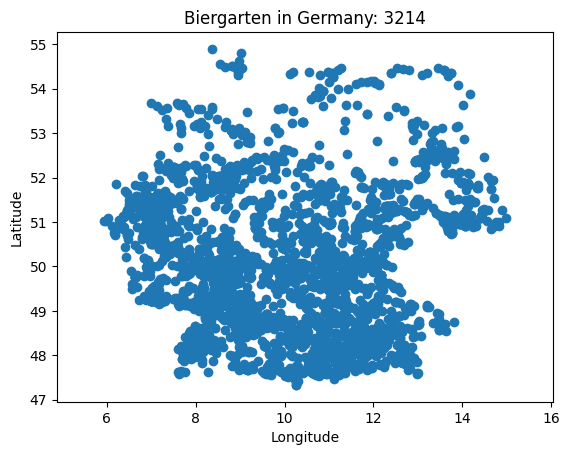

In [4]:
# Example
import requests
import json

overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
[out:json];
area["ISO3166-1"="DE"][admin_level=2];
(node["amenity"="biergarten"](area);
 way["amenity"="biergarten"](area);
 rel["amenity"="biergarten"](area);
);
out center;
"""
response = requests.get(overpass_url,
                        params={'data': overpass_query})
data = response.json()
coords = []
for element in data['elements']:
  if element['type'] == 'node':
    lon = element['lon']
    lat = element['lat']
    coords.append((lon, lat))
  elif 'center' in element:
    lon = element['center']['lon']
    lat = element['center']['lat']
    coords.append((lon, lat))# Convert coordinates into numpy array
X = np.array(coords)
plt.plot(X[:, 0], X[:, 1], 'o')
plt.title(f'Biergarten in Germany: {len(coords)}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('equal')
plt.show()

AssertionError: 

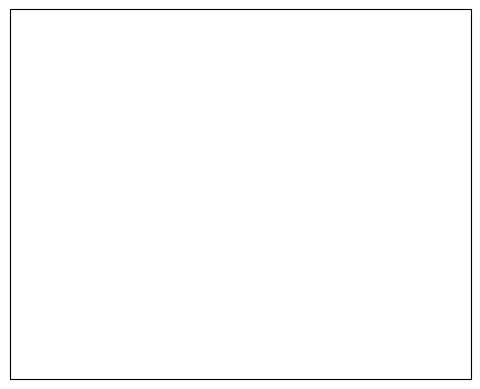

In [8]:
import os
import types

import cartopy.io.img_tiles as img_tiles
import requests
import PIL


class CachedTiler(object):
    def __init__(self, tiler):
        self.tiler = tiler

    def __getattr__(self, name):
        # Mimic the tiler interface, but for methods, ensure that the "self"
        # that is passed through continues to be CachedTiler, and not the
        # contained tiler instance.
        attr = getattr(self.tiler, name, None)
        if isinstance(attr, types.MethodType):
            attr = types.MethodType(attr.im_func, self)
        return attr

    def get_image(self, tile):
        tileset_name = '{}'.format(self.tiler.__class__.__name__.lower())
        print(tileset_name)
        cache_dir = os.path.expanduser(os.path.join('~/', 'image_tiles', tileset_name))
        if not os.path.exists(cache_dir):
            os.makedirs(cache_dir)
        tile_fname = os.path.join(cache_dir, '_'.join(str(v) for v in tile) + '.png')
        if not os.path.exists(tile_fname):
            response = requests.get(self._image_url(tile),
                                    stream=True)

            with open(tile_fname, "wb") as fh:
                for chunk in response:
                    fh.write(chunk)
        with open(tile_fname, 'rb') as fh:
            img = PIL.Image.open(fh)
            img = img.convert(self.desired_tile_form)     
        return img, self.tileextent(tile), 'lower'
    
from cartopy.io.img_tiles import Stamen
import matplotlib.pyplot as plt


actual_tiler = Stamen()
tiler = CachedTiler(actual_tiler)

mercator = tiler.crs
ax = plt.axes(projection=mercator)
ax.set_extent([-90, -73, 22, 34])
# ax.add_image(tiler, 6)
# ax.coastlines('10m')
# plt.show()